In general, I've made two types of additions in esda:

1. functions that apply a given statistic or classifier over an arbitrary set of columns
2. reshaping/typecasting & shaping according to the docstrings of the functions. 

2 came down to wrapping pretty much every input to an esda function in a: 

```python
x = np.asarray(x).reshape(whatever)
```
if what the function was written for expected a flat or a column vector or what have you. 

I've been building other improvements, too, like the metadata stuff that comes with the tabular accessors. I'll show that below.

In [1]:
import pysal as ps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/ljw/.local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
df = ps.open(ps.examples.get_path('south.dbf')).to_df()

In [3]:
df.head()

,FIPSNO,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
0,54029,Hancock,West Virginia,54,029,54029,54,29,1,1.682864,...,2.557262,0.223645,0.295377,0.332251,0.363934,9.981297,7.8,9.785797,12.604552,<pysal.cg.shapes.Polygon object at 0x7f45acc19...
1,54009,Brooke,West Virginia,54,009,54009,54,9,1,4.607233,...,0.748370,0.220407,0.318453,0.314165,0.350569,10.929337,8.0,10.214990,11.242293,<pysal.cg.shapes.Polygon object at 0x7f45acc19...
2,54069,Ohio,West Virginia,54,069,54069,54,69,1,0.974132,...,3.310334,0.272398,0.358454,0.376963,0.390534,15.621643,12.9,14.716681,17.574021,<pysal.cg.shapes.Polygon object at 0x7f45acc19...
3,54051,Marshall,West Virginia,54,051,54051,54,51,1,0.876248,...,0.546097,0.227647,0.319580,0.320953,0.377346,11.962834,8.8,8.803253,13.564159,<pysal.cg.shapes.Polygon object at 0x7f45acc19...
4,10003,New Castle,Delaware,10,003,10003,10,3,1,4.228385,...,16.480294,0.256106,0.329678,0.365830,0.332703,12.035714,10.7,15.169480,16.380903,<pysal.cg.shapes.Polygon object at 0x7f45acc19...


In [4]:
W = ps.weights.Rook.from_dataframe(df)

All of the following columnar application methods should respect the metadata of the input dataframe. Recently, pandas added a `_metadata` list to the dataframe, which essentially allows you to persist methods & attributes between copies of dataframes. 

Right now, I've implemented this as a function, `insert_metadata` in the tabular module. I think it might make sense to add it directly to the dataframe. But, nothing aside from the by_col stuff can find that `W` yet. Where I think it'd be neat would be in something like:

`ML_Lag.from_formula('y ~ X', df)`

where the W is just pulled in from the df metadata.

In [5]:
from pysal.contrib.geotable.utils import insert_metadata

For this, the name is automatically culled from the type of the `W`. 

In [6]:
insert_metadata(df, W, name='W')

In [7]:
df.W

In [8]:
df._metadata

['W']

In [9]:
insert_metadata(df, W)

In [10]:
df._metadata

['W', 'Rook']

In [11]:
df.W == df.Rook

True

it won't overwrite existing metadata

In [12]:
try:
    insert_metadata(df, W, name='W')
except Exception as e:
    print('This would have been raised:', e)

('This would have been raised:', Exception('Dataframe already has attribute W. Cowardly refusing to break dataframe. ',))


unless you tell it to:

In [13]:
insert_metadata(df, W, name='W', overwrite=True)

pysal/contrib/geotable/utils.py:65: UserWarning: Overwriting attribute W! This may break the dataframe!
  warn('Overwriting attribute {}! This may break the dataframe!'.format(name))


### statistics

All the statistics are warpped in `asarray`, so you can pass pretty much any arraylike

In [14]:
ps.Moran_Local(df.HR80, df.W).Is[0:5]

array([ 0.59122198,  0.50869881,  0.40200111,  0.59861622,  0.32358641])

The methods for the statistics are called `by_col`, mimicking the filehandler stuff. They operate on lists of strings (or just one string, if you just want one column) and return the statistic applied with the configuration options over those columns.

In [15]:
stats = ps.Moran_Local.by_col(df, ['HR90', 'HR80', 'HR70'])

In [16]:
stat_cols = [col for col in stats.columns if col.startswith('HR')]
mis = [col for col in stat_cols if col.endswith('moran_local')]

In [17]:
stats[stat_cols].head()

,HR60,HR70,HR80,HR90,HR90_moran_local,HR90_p_sim,HR80_moran_local,HR80_p_sim,HR70_moran_local,HR70_p_sim
0,1.682864,4.192978,6.597720,0.946083,1.443729,0.087,0.591222,0.116,0.693289,0.144
1,4.607233,3.284827,3.213677,1.234934,1.303192,0.029,0.508699,0.254,0.633980,0.125
2,0.974132,5.254391,7.601796,2.621009,0.937053,0.045,0.402001,0.060,0.528287,0.085
3,0.876248,4.432860,4.005640,4.461577,0.757154,0.040,0.598616,0.169,0.728111,0.038
4,4.228385,6.738265,7.116872,6.712736,0.241699,0.118,0.323586,0.112,0.103081,0.367


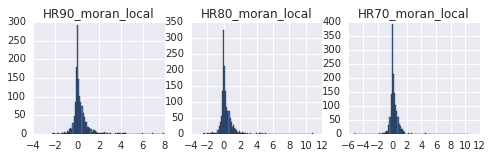

In [18]:
f,ax = plt.subplots(1,3, figsize=(8, 2))
for a, col in zip(ax, mis):
    a.hist(stats[col].values, bins=100)
    a.set_title(col)
plt.show()

In [19]:
stats = ps.Moran_Local.by_col(df, 'HR90', permutations=9)

In [20]:
stats['HR90_moran_local'].head()

0    1.443729
1    1.303192
2    0.937053
3    0.757154
4    0.241699
Name: HR90_moran_local, dtype: float64

It can also be done by updating the dataframe inplace. Like most pandas functions, I made it copy by default. Also, you can specify arbitrary attributes of the object that you want to turn into columns.

In [21]:
ps.Moran_Local.by_col(df, 'GI89', permutations=1000, 
                      outvals=['p_z_sim'], inplace=True)
df[[col for col in df.columns if col.startswith('GI89')]].head()

,GI89,GI89_moran_local,GI89_p_z_sim,GI89_p_sim
0,0.363934,1.008983,0.125209,0.098901
1,0.350569,0.547154,0.283638,0.270729
2,0.390534,0.058397,0.110480,0.097902
3,0.377346,-0.015205,0.494106,0.486513
4,0.332703,1.822810,0.032565,0.027972


The bivariate stuff uses two sets of columns. They'are assumed surjective. So:
1. if there is only one variate passed (string or list), it's repeated for all other columns. 
2.  `y=x` if `y` is empty, so if there is no `y` list passed, elementwise comparisons are done within the `x` list, like `Moran_BV_matrix`
3. if `p` `x` covariates are passed and `q` y covariates are passed, an error is raised flagging that there's not a one-to-one mapping. 

In [22]:
stats = ps.Moran_Local_BV.by_col(df, ['HR90', 'HR80'], 'HR70')
stat_cols = [col for col in stats.columns if col.startswith('HR')]
mis = [col for col in stats if col.endswith('moran_local_bv')]
stats[mis].head()

,HR90-HR70_moran_local_bv,HR80-HR70_moran_local_bv
0,1.089638,0.492041
1,0.840000,0.761771
2,0.806675,0.326055
3,0.703970,0.924931
4,0.090582,0.106153


The rate stuff matches one-to-one, too, between events and populations, and will also scale events to match populations (or vice versa). But, it won't compute combinations between the lists, and does not complete if passed only one list.

In [23]:
sids = ps.open(ps.examples.get_path('sids2.dbf')).to_df()
W = ps.open(ps.examples.get_path('sids2.gal')).read()

In [24]:
stats = ps.esda.moran.Moran_Local_Rate.by_col(sids, ['SID74', 'SID79'], 
                                            ['BIR74', 'BIR79'], w=W)

In [25]:
stat_cols = [col for col in stats if col.endswith('rate')]

In [26]:
stats[stat_cols].head()

,SID74-BIR74_moran_local_rate,SID79-BIR79_moran_local_rate
0,0.557723,-0.134524
1,0.535580,-1.211340
2,0.379260,0.050198
3,0.069379,0.061271
4,4.416906,-0.126275


Unfortunately, `df.query` doesn't work quite right when the column contains an algebraic operator, so I'm considering just making everything underscores. Not sure yet. 

In [27]:
try:
    stats.query('SID74-BIR74_moran_local_rate <= .01').head()
except Exception as e:
    print('the numexpr parser is very eager, and misreads '
           'A-B_moran_local_rate!\n{}'.format(e))

the numexpr parser is very eager, and misreads A-B_moran_local_rate!
name 'BIR74_moran_local_rate' is not defined


And, this isn't just on the moran stuff:

In [28]:
ps.G_Local.by_col(df, 'HR90')['HR90_g_local'].head()

0    0.000092
1    0.000132
2    0.000211
3    0.000161
4    0.000395
Name: HR90_g_local, dtype: float64

nor the local stuff:

In [29]:
ps.Gamma.by_col(df, ['BLK80'], operation='a')['BLK80_gamma'].head()

0    10830.853847
1    10830.853847
2    10830.853847
3    10830.853847
4    10830.853847
Name: BLK80_gamma, dtype: float64

### classifiers

This is where I went into exploring partial application. Essentially, to make it easy to do `dataframe.apply(classifier)`, we needed some way to create a closure around the `__init__` function. 

I detail my initial exploration in this [in this gist](http://nbviewer.jupyter.org/gist/ljwolf/80b7f6518e44688ed85c8d9f3c67613e), where I make the Local Moran function partially applicative. 


In addition, this allows us to do rolling classifiers directly, whereas before we had to chain an update & a reclassify. So, say we have data $x_1, x_2, ...$ that we want to classify (like a rolling window or something). We have some classifier function `Classifier(**configs)`, and the closure around it, which I've just simply called `classifier`, stores the actual *instance* of the classified data seen so far. So, we get:

```python
cfunc = Classifier(rolling=True, **configs)
x1b = cfunc(x1) #Classifier(x1, **configs).yb
x2b = cfunc(x2) #Classifier(x1 U x2 **configs).find_bin(x2)
x3b = cfunc(x3) #Classifier(x1 U x2 U x3, **configs).find_bin(x3)
```

I thought this idea was pretty cool. But, I think making classes partially applicative by default is probably less than pythonic so I stuffed it into a separate method, `make`.

I wrote this to make it easy to use with `dataframe.apply`, but it's not dataframe-specific, and could work on any set of chunked data. Let's cook a small example to show how it works. 

In [30]:
import pandas as pd

In [31]:
#ps.Quantiles.make?

In [32]:
small_data = np.arange(0, 18, 1).reshape(6,3)

In [33]:
small_data[:,1] = list(reversed(small_data[:,1]))

In [34]:
small_data = np.hstack((small_data, np.roll(small_data, 4)))
small_data

array([[ 0, 16,  2, 14, 15,  1],
       [ 3, 13,  5, 17,  0, 16],
       [ 6, 10,  8,  2,  3, 13],
       [ 9,  7, 11,  5,  6, 10],
       [12,  4, 14,  8,  9,  7],
       [15,  1, 17, 11, 12,  4]])

In [35]:
small_df = pd.DataFrame(small_data, columns=[chr(x) for x in range(65, 71)])

In [36]:
small_df

,A,B,C,D,E,F
0,0,16,2,14,15,1
1,3,13,5,17,0,16
2,6,10,8,2,3,13
3,9,7,11,5,6,10
4,12,4,14,8,9,7
5,15,1,17,11,12,4


So, the `make` function takes anything the `__init__` does, as well as an extra `rolling` argument, that does what I mentioned above. 

In [37]:
classifier = ps.Quantiles.make(k=4, rolling=False)

Classifier is a closure around `ps.Quantiles` that has bound the `k` option to the constructor (as well as all the rest of the default values). So, it just takes `x` and returns `yb`, according to `**configs`. It's configuration is immutable after runtime, unless you wanna poke around inside of the closure. 

So, you can just apply this over the columns you want to classify. 

In [38]:
small_df.apply(classifier)

,A,B,C,D,E,F
0,0,3,0,3,3,0
1,0,3,0,3,0,3
2,1,2,1,0,0,3
3,2,1,2,0,1,2
4,3,0,3,1,2,1
5,3,0,3,2,3,0


And, of course, you can combine that into a single call:

In [39]:
small_df.apply(ps.Quantiles.make(k=4))

,A,B,C,D,E,F
0,0,3,0,3,3,0
1,0,3,0,3,0,3
2,1,2,1,0,0,3
3,2,1,2,0,1,2
4,3,0,3,1,2,1
5,3,0,3,2,3,0


This is a more concise version of the lambda that does a similar thing without closure:

In [40]:
small_df.apply(lambda x: ps.Quantiles(x, k=4).yb)

,A,B,C,D,E,F
0,0,3,0,3,3,0
1,0,3,0,3,0,3
2,1,2,1,0,0,3
3,2,1,2,0,1,2
4,3,0,3,1,2,1
5,3,0,3,2,3,0


But, the closure allows the following. 

First, we make a rolling quantile classifier:

In [41]:
roller = ps.Quantiles.make(k=4, rolling=True)

It can be used just like a regular classifier above:

In [42]:
small_df.apply(roller)

,A,B,C,D,E,F
0,0,3,0,3,3,0
1,1,3,1,3,0,3
2,1,2,1,0,0,3
3,2,1,2,1,1,2
4,3,1,3,1,2,1
5,3,0,3,2,2,1


But, you see that some cells are different, since the classifications change as the columns to the left are included. You can see this really obviously in a more obviously-structured array:

In [43]:
easy_gradient = np.arange(0,25).reshape(5,5)
easy_gradient

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [44]:
tmp_roller = ps.Quantiles.make(k=4, rolling=True)
[tmp_roller(a) for a in easy_gradient]

[array([0, 1, 2, 3, 3]),
 array([2, 2, 3, 3, 3]),
 array([2, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3])]

In [45]:
non_roller = ps.Quantiles.make(k=4, rolling=False)
[non_roller(a) for a in easy_gradient]

[array([0, 0, 1, 2, 3]),
 array([0, 0, 1, 2, 3]),
 array([0, 0, 1, 2, 3]),
 array([0, 0, 1, 2, 3]),
 array([0, 0, 1, 2, 3])]

In [46]:
tmp_roller(np.arange(0,5))

array([0, 0, 0, 0, 1])

If you're really interested in going under the hood, you can actually inspect the closure. I'll do that now to show that the rolling classifier really does accrete data.

In [47]:
small_df

,A,B,C,D,E,F
0,0,16,2,14,15,1
1,3,13,5,17,0,16
2,6,10,8,2,3,13
3,9,7,11,5,6,10
4,12,4,14,8,9,7
5,15,1,17,11,12,4


In [48]:
roller = ps.Quantiles.make(k=4, rolling=True)

In [49]:
roller(small_df.A)

array([0, 0, 1, 2, 3, 3])

In [50]:
roller.func_defaults[0], roller.func_defaults[0].y

(               Quantiles               
  
 Lower            Upper            Count
          x[i] <=  3.750               2
  3.750 < x[i] <=  7.500               1
  7.500 < x[i] <= 11.250               1
 11.250 < x[i] <= 15.000               2,
 array([  0.,   3.,   6.,   9.,  12.,  15.]))

In [51]:
roller(small_df.B)

array([3, 3, 2, 1, 1, 0])

In [52]:
roller.func_defaults[0], roller.func_defaults[0].y

(               Quantiles               
  
 Lower            Upper            Count
          x[i] <=  3.750               3
  3.750 < x[i] <=  8.000               3
  8.000 < x[i] <= 12.250               3
 12.250 < x[i] <= 16.000               3,
 array([ 16.,  13.,  10.,   7.,   4.,   1.,   0.,   3.,   6.,   9.,  12.,
         15.]))

In [53]:
roller(small_df.C)

array([0, 1, 1, 2, 3, 3])

In [54]:
roller.func_defaults[0], roller.func_defaults[0].y

(               Quantiles               
  
 Lower            Upper            Count
          x[i] <=  4.250               5
  4.250 < x[i] <=  8.500               4
  8.500 < x[i] <= 12.750               4
 12.750 < x[i] <= 17.000               5,
 array([  2.,   5.,   8.,  11.,  14.,  17.,  16.,  13.,  10.,   7.,   4.,
          1.,   0.,   3.,   6.,   9.,  12.,  15.]))

**Be careful expecting this to work on columnar dataframes & series, though.**

Apply on a series is *down*, not columnar/across.

In [55]:
rollercoaster = range(0,10) + range(10,-10,-1) + range(-10,20)

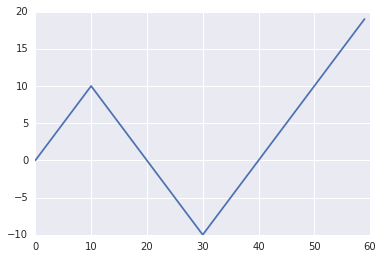

In [56]:
plt.plot(rollercoaster)

In [57]:
roller = ps.Quantiles.make(k=5, rolling=True)

In [58]:
rollercoaster = pd.Series(rollercoaster)

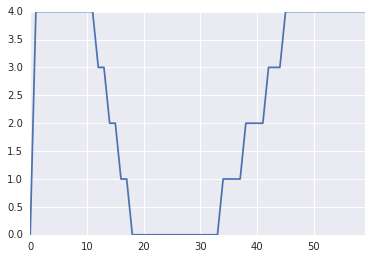

In [59]:
steppercoaster = pd.Series(rollercoaster).apply(roller)
steppercoaster.plot()

and the double application:

In [60]:
two_timer = ps.Quantiles.make(k=3, rolling=True)

In [61]:
small_df[['A']].apply(two_timer)

,A
0,0
1,0
2,1
3,1
4,2
5,2


In [62]:
two_timer.func_defaults[0]

               Quantiles               
 
Lower            Upper            Count
         x[i] <=  5.000               4
 5.000 < x[i] <= 10.000               4
10.000 < x[i] <= 15.000               4

In [63]:
4 + 4 + 4 == 6 * 2

True

### smoother

Finally, I wrapped the smoothers in `asarray` and provided bycol methods as well.

In [64]:
from pysal.esda import smoothing as sm

In [65]:
sids = ps.open(ps.examples.get_path('sids2.dbf')).to_df()

In [66]:
sm.Excess_Risk(sids.SID79, sids.BIR79).r

array([[ 0.        ],
       [ 2.79660658],
       [ 0.83836326],
       [ 1.21747853],
       [ 0.94381119],
       [ 1.37446569],
       [ 2.88716336],
       [ 1.70119053],
       [ 0.84916569],
       [ 1.23958191],
       [ 0.80647021],
       [ 0.46904344],
       [ 0.97445244],
       [ 1.1290583 ],
       [ 1.10117019],
       [ 1.92455994],
       [ 0.88835796],
       [ 0.94946983],
       [ 0.28464991],
       [ 0.        ],
       [ 0.56201734],
       [ 0.        ],
       [ 0.32222805],
       [ 0.        ],
       [ 0.57912408],
       [ 0.93460723],
       [ 0.96372281],
       [ 1.56328462],
       [ 0.67698114],
       [ 1.06552712],
       [ 0.68159089],
       [ 1.09957255],
       [ 1.04319392],
       [ 1.07020059],
       [ 0.58141955],
       [ 0.27325775],
       [ 0.75096424],
       [ 1.09126045],
       [ 0.4678274 ],
       [ 1.05407564],
       [ 0.60042019],
       [ 0.5658727 ],
       [ 1.75679273],
       [ 0.        ],
       [ 0.        ],
       [ 1

In [67]:
#sm.Excess_Risk?

In [68]:
er = sm.Excess_Risk.by_col(sids, ['SID74', 'SID79'], ['BIR74', 'BIR79'])
er[[col for col in er.columns if col.endswith('excess_risk')]].head()

,SID74-BIR74_excess_risk,SID79-BIR79_excess_risk
0,0.453433,0.000000
1,0.000000,2.796607
2,0.775871,0.838363
3,0.973810,1.217479
4,3.133189,0.943811


In [69]:
W = ps.open(ps.examples.get_path('sids2.gal')).read()

In [70]:
sm.Disk_Smoother(sids.SID79, sids.BIR79, W)

In [71]:
sm.Disk_Smoother.by_col(sids, 'SID79', 'BIR79', w=W).head()

,AREA,PERIMETER,CNTY_,CNTY_ID,NAME,FIPS,FIPSNO,CRESS_ID,BIR74,SID74,NWBIR74,BIR79,SID79,NWBIR79,SIDR74,SIDR79,NWR74,NWR79,geometry,SID79-BIR79_disk_smoother
0,0.114,1.442,1825,1825,Ashe,37009,37009,5,1091.0,1.0,10.0,1364.0,0.0,19.0,0.916590,0.000000,9.165903,13.929619,<pysal.cg.shapes.Polygon object at 0x7f45a28e7...,0.002659
1,0.061,1.231,1827,1827,Alleghany,37005,37005,3,487.0,0.0,10.0,542.0,3.0,12.0,0.000000,5.535055,20.533881,22.140221,<pysal.cg.shapes.Polygon object at 0x7f45a2b0a...,0.001179
2,0.143,1.630,1828,1828,Surry,37171,37171,86,3188.0,5.0,208.0,3616.0,6.0,260.0,1.568381,1.659292,65.244668,71.902655,<pysal.cg.shapes.Polygon object at 0x7f45a23aa...,0.002330
3,0.070,2.968,1831,1831,Currituck,37053,37053,27,508.0,1.0,123.0,830.0,2.0,145.0,1.968504,2.409639,242.125984,174.698795,<pysal.cg.shapes.Polygon object at 0x7f45a23aa...,0.003329
4,0.153,2.206,1832,1832,Northampton,37131,37131,66,1421.0,9.0,1066.0,1606.0,3.0,1197.0,6.333568,1.867995,750.175932,745.330012,<pysal.cg.shapes.Polygon object at 0x7f45a23aa...,0.002826
